In [1]:
pip install tensorflow matplotlib tensoflow-datasets ipywidgets

ERROR: Could not find a version that satisfies the requirement tensoflow-datasets (from versions: none)
ERROR: No matching distribution found for tensoflow-datasets
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# 1. Setting up and limiting GPU

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2025-10-08 11:25:37.448669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 11:25:37.923532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759937138.103431    1701 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759937138.162658    1701 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759937138.662248    1701 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 2. Importing the data #

In [3]:
### I imported the data 

In [4]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the metadata
df = pd.read_csv("house_plans_details.csv")

# Optional: inspect it
print(df.head())

# Define image size
IMG_SIZE = (64, 64)

def load_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

images = []
tabular_data = []

for i, row in df.iterrows():
    img_path = row['Image Path']
    if os.path.exists(img_path):
        images.append(load_image(img_path))
        # Use the numeric features: Square Feet, Beds, Baths, Garages
        tabular_data.append([row['Square Feet'], row['Beds'], row['Baths'], row['Garages']])
    else:
        print(f"Missing image: {img_path}")

   Square Feet  Beds  Baths  Garages      Image Path
0       3041.0   3.0    2.5      2.0  images/0_1.jpg
1        784.0   1.0    1.0      1.0  images/0_2.jpg
2       2486.0   3.0    2.5      1.0  images/0_3.jpg
3       2220.0   3.0    2.0      1.0  images/0_4.jpg
4       3776.0   3.0    3.5      1.0  images/0_5.jpg


In [6]:
len(tabular_data)

2640

In [7]:
len(images)

2640

In [8]:
print(type(images))

<class 'list'>


In [9]:
npArray_images = np.array(images)

In [10]:
npArray_tabular_data = np.array(tabular_data)

In [11]:
ds = (npArray_images, npArray_tabular_data)

In [12]:
imageDS = tf.data.Dataset.from_tensor_slices(images)

I0000 00:00:1759937165.869538    1701 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
tfDataset = tf.data.Dataset.from_tensors(ds, name= 'datasetTF')

In [14]:
imageIterator = imageDS.as_numpy_iterator()

In [15]:
tfDataset

<_TensorDataset element_spec=(TensorSpec(shape=(2640, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2640, 4), dtype=tf.float64, name=None))>

## Using the iterator for my training loop means that I do not need to load the training data into memory all at once. I can just use the iterator to load each record as I need it, saving some memory in the process ##

In [16]:
tfds_images = tf.data.Dataset.from_tensors(tfds_tuple_images)

NameError: name 'tfds_tuple_images' is not defined

In [ ]:
tfds_image_iterator = tfds_images

In [ ]:
for element in tfDataset:
    print(element)

In [ ]:
imageDS.element_spec

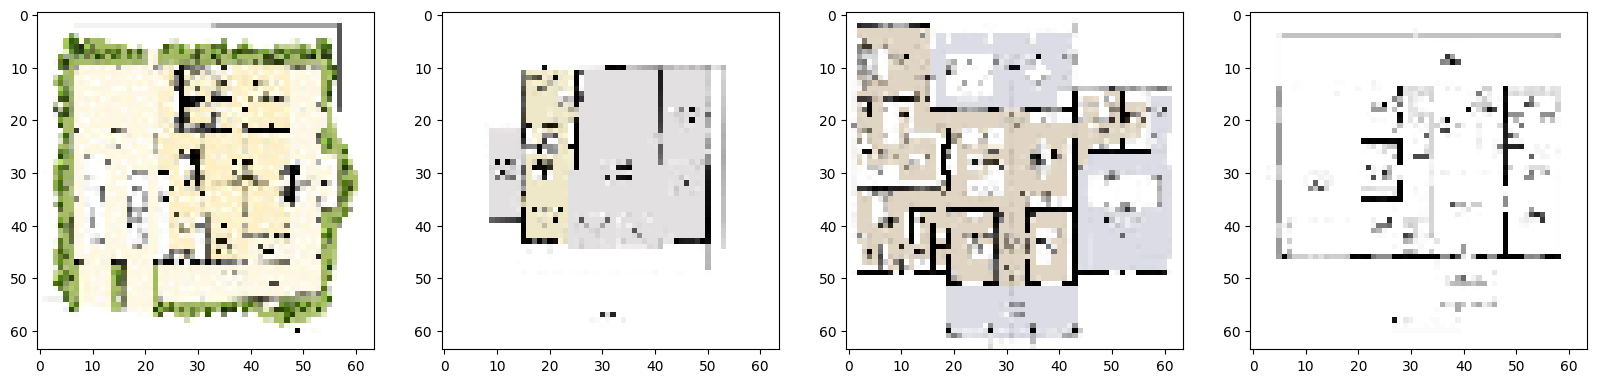

In [17]:
from matplotlib import pyplot as plt
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = imageIterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample))
   

### Preprocessing

In [18]:
imageDS = imageDS.cache()
imageDS = imageDS.shuffle(60000)
imageDS = imageDS.batch(128)
imageDS = imageDS.prefetch(64)

In [19]:
imageDS.as_numpy_iterator().next().shape

(128, 64, 64, 3)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose

def build_generator(latent_dim=100, num_classes=4, img_shape=(64,64,3)):
    """
    Builds and returns a generator model for a cGAN.
    
    Parameters:
        latent_dim: Dimension of the latent noise vector
        num_classes: Number of classes (for conditional GAN)
        img_shape: Shape of the output image
    
    Returns:
        generator: Keras Sequential model
    """
    generator = Sequential([
        # Fully connected layer to expand input
        Dense(128*8*8, input_dim=latent_dim + num_classes),
        LeakyReLU(0.2),
        BatchNormalization(),
        
        # Reshape to small feature map
        Reshape((8, 8, 128)),
        
        # Upsampling block 1
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(),
        # Upsampling block 2
        Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(),

        
        
        # Upsampling block 3 → output image
        Conv2DTranspose(img_shape[2], kernel_size=4, strides=2, padding="same", activation="tanh")
    ])
    
    return generator
gen = build_generator()
gen.summary()



/home/chibu/.venvs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       860,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,787 (4.04 MB)

 Trainable params: 1,042,211 (3.98 MB)

 Non-trainable params: 16,576 (64.75 KB)

In [21]:
gen.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       860,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,787 (4.04 MB)

 Trainable params: 1,042,211 (3.98 MB)

 Non-trainable params: 16,576 (64.75 KB)

In [43]:
noise = np.random.randn(104)  # shape: (104,)
noise = noise.reshape(1, -1)  # shape: (1, 104), batch of 1
output = gen.predict(noise)

I0000 00:00:1758492770.525687     747 service.cc:152] XLA service 0x7a85d8014d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758492770.525792     747 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-09-21 18:12:50.558115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758492770.630086     747 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1758492771.830112     747 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [53]:
output.shape

(1, 64, 64, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030825017..0.031334136].


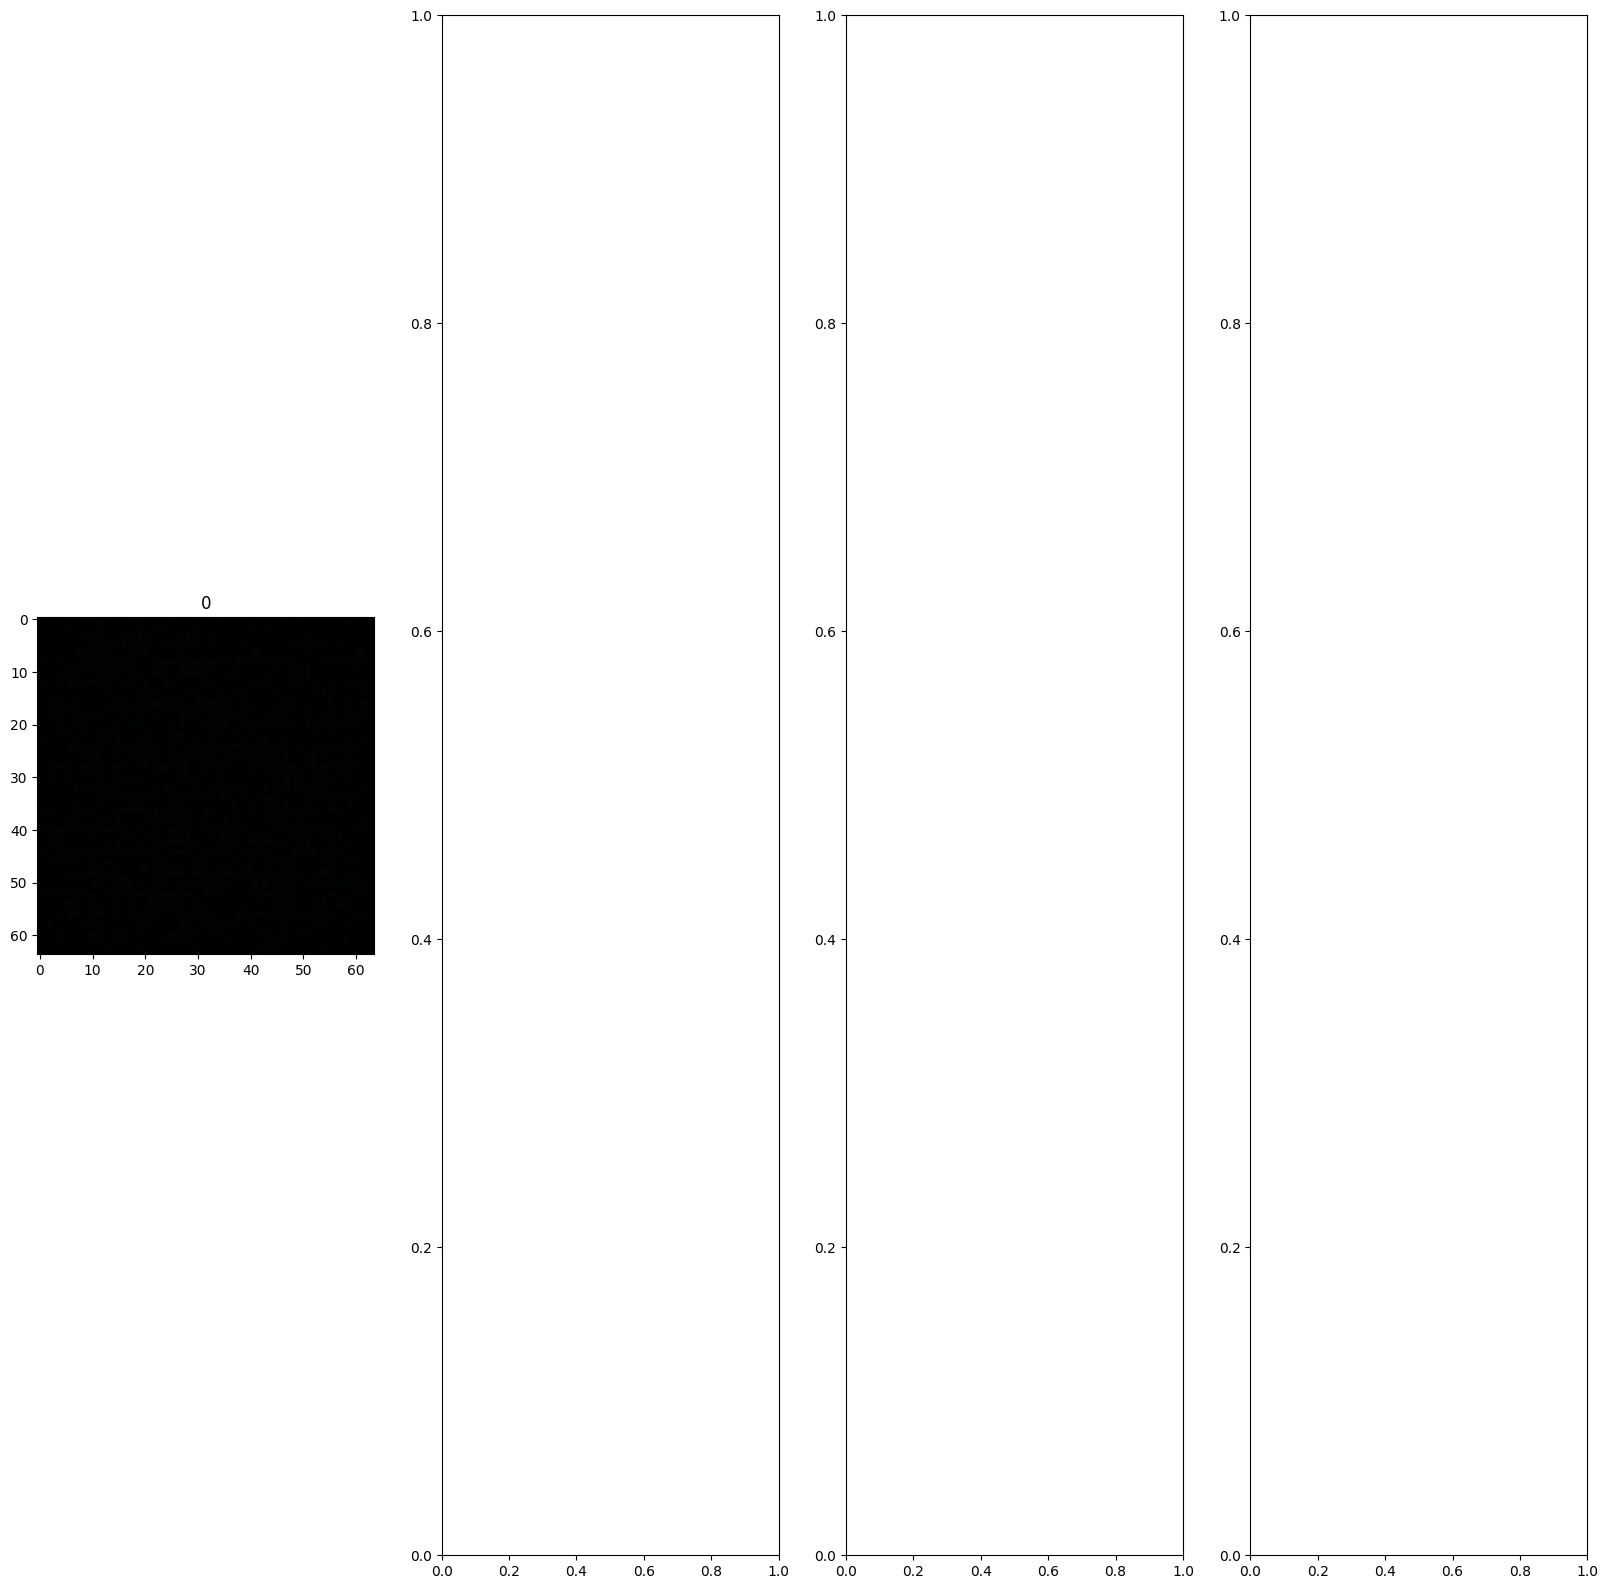

In [23]:
# Generate new fashion
img = gen.predict((np.random.rand(104)).reshape(1, -1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [44]:
from tensorflow.keras import layers, Model, Input

def build_discriminator(img_shape=(64, 64, 3), condition_dim=4):
    # Image branch
    img_input = Input(shape=img_shape, name="image_input")
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    img_features = layers.Dense(128)(x)

    # Condition (tabular) branch
    cond_input = Input(shape=(condition_dim,), name="condition_input")
    y = layers.Dense(64)(cond_input)
    y = layers.LeakyReLU(0.2)(y)
    y = layers.Dense(128)(y)
    y = layers.LeakyReLU(0.2)(y)

    # Combine both branches
    combined = layers.Concatenate()([img_features, y])
    z = layers.Dense(256)(combined)
    z = layers.LeakyReLU(0.2)(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(1, activation='sigmoid')(z)  # output: real/fake

    discriminator = Model([img_input, cond_input], z, name="discriminator")
    return discriminator
    

In [45]:

discriminator = build_discriminator()
#discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,136 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    524,544 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ condition_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        320 │ condition_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 64)        │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      8,320 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 256)       │          0 │ dense_4[0][0]   

 Total params: 2,832,385 (10.80 MB)

 Trainable params: 2,831,617 (10.80 MB)

 Non-trainable params: 768 (3.00 KB)

In [46]:
from tensorflow.keras.optimizers import Adam
#Compile discriminator
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)


In [48]:
print(type(tabular_data))

<class 'list'>


In [49]:
# -----------------------------
# 1️⃣ Normalize tabular_data
# -----------------------------
tabular_data = np.array(tabular_data, dtype=np.float32)  # shape: (num_samples, 4)

# Min-Max normalization per feature
min_vals = tabular_data.min(axis=0)
max_vals = tabular_data.max(axis=0)
tabular_data_norm = (tabular_data - min_vals) / (max_vals - min_vals)

condition_dim = tabular_data.shape[1]

In [51]:
# -----------------------------
# 2️⃣ Prepare tf.data.Dataset
# -----------------------------
batch_size = 128

# Assume image_ds is a tf.data.Dataset of shape (64,64,3) per image
condition_ds = tf.data.Dataset.from_tensor_slices(tabular_data_norm)

# Zip images and conditions
full_dataset = tf.data.Dataset.zip((imageDS, condition_ds))
full_dataset = full_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [53]:
# -----------------------------
# 3️⃣ Compile Discriminator & GAN
# -----------------------------
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, beta_1=0.5),
    metrics=['accuracy']
)

# Build combined GAN
discriminator.trainable = False
noise_dim = 100
noise_input = tf.keras.Input(shape=(noise_dim,))
condition_input = tf.keras.Input(shape=(condition_dim,))
generated_image = gen([noise_input, condition_input])
validity = discriminator([generated_image, condition_input])
gan_model = tf.keras.Model([noise_input, condition_input], validity)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, beta_1=0.5))

ValueError: Exception encountered when calling Sequential.call().

[1mLayer "functional" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 100), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>][0m

Arguments received by Sequential.call():
  • args=(['<KerasTensor shape=(None, 100), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>', '<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>'],)
  • kwargs={'mask': ['None', 'None']}